In [8]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


perform = pd.read_csv('./horse/data/perform_clean.csv', sep=',', encoding='utf-8')
perform['speed'] = perform['distance']/perform['finish_time']
perform['is_champ'] = perform['pla'].apply(lambda x: 1 if x==1 else 0)

y_cols = ['is_champ', 'pla', 'finish_time', 'speed']
date_cols = ['race_key', 'race_date']

get_x_cols = lambda x: [col for col in x if (col not in y_cols) and (col not in date_cols)]
x_cols = get_x_cols(perform.columns)

perform.head(5)

,race_key,race_date,dr,distance,field_going,course_type,race_money,act_wt,declare_horse_wt,win_odds,horse,jockey,trainer,is_champ,pla,finish_time,speed
0,2015/04/22_1,2015/04/22,2,1000,好地至快地,草地,575000,120,1186,7.3,有情風(N139),薛寶力,吳定強,1,1,57.37,17.430713
1,2015/04/22_1,2015/04/22,3,1000,好地至快地,草地,575000,132,1022,6.1,樂趣(S150),韋達,霍利時,0,2,57.53,17.382235
2,2015/04/22_1,2015/04/22,5,1000,好地至快地,草地,575000,121,1085,48.0,穩佔先機(N359),連達文,苗禮德,0,3,57.78,17.307027
3,2015/04/22_1,2015/04/22,7,1000,好地至快地,草地,575000,127,1211,7.8,上浦勇將(P285),田泰安,徐雨石,0,4,57.82,17.295054
4,2015/04/22_1,2015/04/22,1,1000,好地至快地,草地,575000,124,1088,14.0,大地王者(L251),黎海榮,李易達,0,5,57.89,17.274141


## 2 Feature Process

### 2.1 Categorization

In [9]:
# low cardinality, encoding with 0/1
perform.course_type.unique() # '草地', '全天候跑道'; nunique=2
perform.course_type = perform.course_type.replace({'全天候跑道':0, '草地':1})

# high cardinality, encoding with embedding. 
#   Note: Emb value is in model, here only process with mapping index
def col2ix(df_col:pd.Series):
    """ Mapping from column's item to indecies.

        Returns:
            ix2item: dict
                with key as index, value is the hashed item
            item2ix: dict
                with key as item, value as its index
    """
    ix = list(range(df_col.nunique()))
    item = df_col.unique().tolist()

    return dict(zip(ix, item)), dict(zip(item, ix))

# mapping dict
ix2field, field2ix = col2ix(perform['field_going'])
ix2jockey, jockey2ix = col2ix(perform['jockey'])
ix2horse, horse2ix = col2ix(perform['horse'])
ix2trainer, trainer2ix = col2ix(perform['trainer'])

# perform after mapping
perform['field_going'] = perform['field_going'].apply(lambda x: field2ix[x])
perform['jockey'] = perform['jockey'].apply(lambda x: jockey2ix[x])
perform['horse'] = perform['horse'].apply(lambda x: horse2ix[x])
perform['trainer'] = perform['trainer'].apply(lambda x: trainer2ix[x])


perform.head(5)

,race_key,race_date,dr,distance,field_going,course_type,race_money,act_wt,declare_horse_wt,win_odds,horse,jockey,trainer,is_champ,pla,finish_time,speed
0,2015/04/22_1,2015/04/22,2,1000,0,1,575000,120,1186,7.3,0,0,0,1,1,57.37,17.430713
1,2015/04/22_1,2015/04/22,3,1000,0,1,575000,132,1022,6.1,1,1,1,0,2,57.53,17.382235
2,2015/04/22_1,2015/04/22,5,1000,0,1,575000,121,1085,48.0,2,2,2,0,3,57.78,17.307027
3,2015/04/22_1,2015/04/22,7,1000,0,1,575000,127,1211,7.8,3,3,3,0,4,57.82,17.295054
4,2015/04/22_1,2015/04/22,1,1000,0,1,575000,124,1088,14.0,4,4,4,0,5,57.89,17.274141


### 2.2 Scaling

In [10]:
def zscore_standarlization(col):
    return (col-col.mean())/col.std()

perform['distance'] = zscore_standarlization(perform['distance'])
perform['race_money'] = zscore_standarlization(perform['race_money'])
perform['act_wt'] = zscore_standarlization(perform['act_wt'])
perform['declare_horse_wt'] = zscore_standarlization(perform['declare_horse_wt'])

perform.head()

,race_key,race_date,dr,distance,field_going,course_type,race_money,act_wt,declare_horse_wt,win_odds,horse,jockey,trainer,is_champ,pla,finish_time,speed
0,2015/04/22_1,2015/04/22,2,-1.404898,0,1,-0.394974,-0.540745,1.080522,7.3,0,0,0,1,1,57.37,17.430713
1,2015/04/22_1,2015/04/22,3,-1.404898,0,1,-0.394974,1.432011,-1.417146,6.1,1,1,1,0,2,57.53,17.382235
2,2015/04/22_1,2015/04/22,5,-1.404898,0,1,-0.394974,-0.376349,-0.457676,48.0,2,2,2,0,3,57.78,17.307027
3,2015/04/22_1,2015/04/22,7,-1.404898,0,1,-0.394974,0.610030,1.461264,7.8,3,3,3,0,4,57.82,17.295054
4,2015/04/22_1,2015/04/22,1,-1.404898,0,1,-0.394974,0.116841,-0.411987,14.0,4,4,4,0,5,57.89,17.274141


<AxesSubplot:>

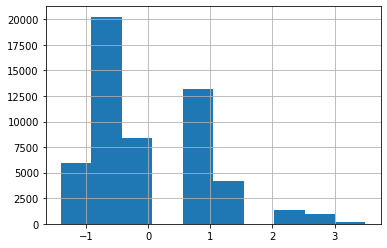

In [11]:
perform.distance.hist()

In [12]:
from horse.process import train_test_split

perform_train, perform_test = train_test_split(perform, 'race_date', 0.1)
perform_train, perform_val = train_test_split(perform_train, 'race_date', 0.5)

perform.shape, perform_train.shape, perform_val.shape, perform_test.shape

((54436, 17), (25048, 17), (23667, 17), (5721, 17))

## 3 Modeling

In [13]:
from torch import FloatTensor, LongTensor

y_col = ['is_champ']
numerical_cols = ['distance', 'course_type', 'race_money', 'act_wt', 'declare_horse_wt', 'dr']
categ_cols = ['field_going', 'horse', 'jockey', 'trainer']
x_cols = numerical_cols + categ_cols

def get_feats(data, numerical_cols, y_col):
    num = FloatTensor(data[numerical_cols].values)
    f = LongTensor(data['field_going'].values)
    j = LongTensor(data['jockey'].values)
    h = LongTensor(data['horse'].values)
    t = LongTensor(data['trainer'].values)
    y = FloatTensor(data[y_col].values)

    X = (num, f, j, h, t)
    return X, y

def horse_data_loader(X, y, batch_size, shuffle):
    from torch.utils.data import DataLoader

    return DataLoader(list(zip(*X, y)), batch_size=batch_size, shuffle=shuffle)

def create_data_batch(data, numerical_cols, y_col, batch_size, shuffle=True):
    X, y = get_feats(data, numerical_cols, y_col)

    return horse_data_loader(X, y, batch_size, shuffle)

dl = create_data_batch(perform_train, numerical_cols, y_col, 12)

In [14]:
from horse.process import racing_champ, AveragePrecision

def prep_eval_data(perform):
    """
    ((race_key, dr), (X, f, j, h, t))
    """
    keys = (perform[['race_key', 'dr']])
    X, y = get_feats(perform, numerical_cols, y_col)

    return keys, X

def computeAP(dataset, model, way='min'):
    func = min if way=='min' else max
    ground_truth = racing_champ(dataset)
    result, X = prep_eval_data(dataset)
    score = model(*X)
    result['win'] = score.detach().numpy()
    result = result.groupby(['race_key']) \
                .apply(lambda x: x[x['win']==func(x['win'])]) \
                .reset_index(drop=True)[['race_key', 'dr']]

    return AveragePrecision(result, ground_truth)

In [21]:
import torch.nn as nn
from torch import Tensor, LongTensor
from torch import autograd, device
from torch import optim
import torch
import time
import numpy as np


class LinearRegWEmb(nn.Module):
    """ Simple Concat + Linear txfm for all embeddings """
    def __init__(self, n_num_feats, k_dim_field, k_dim_id) -> None:
        super(LinearRegWEmb, self).__init__()
        self.n_num_feats = n_num_feats
        self.sigmoid = torch.sigmoid
        # init embedding for ids
        self.emb_field = nn.Embedding(len(field2ix), k_dim_field)
        self.emb_jockey = nn.Embedding(len(jockey2ix), k_dim_id)
        self.emb_horse = nn.Embedding(len(horse2ix), k_dim_id)
        self.emb_trainer = nn.Embedding(len(trainer2ix), k_dim_id)
        # output layer
        out_dim = n_num_feats + k_dim_field + 3*k_dim_id
        self.Linear = nn.Linear(out_dim, 1)
        # init all dims
        nn.init.normal_(self.Linear.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_field.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_jockey.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_horse.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_trainer.weight, mean=0, std=0.1)

    def forward(self, x, field, jockey, horse, trainer):
        emb_f = self.emb_field(field)
        emb_j = self.emb_jockey(jockey)
        emb_h = self.emb_horse(horse)
        emb_t = self.emb_trainer(trainer)

        out = self.Linear(torch.concat([x, emb_f, emb_j, emb_h, emb_t], 1))
        return self.sigmoid(out)


class LinearRegWEmbv1(nn.Module):
    """ Dot All Embs into 1d for scale reduction """
    def __init__(self, n_num_feats, k_dim_field, k_dim_id) -> None:
        super(LinearRegWEmbv1, self).__init__()
        self.n_num_feats = n_num_feats
        self.sigmoid = torch.sigmoid
        # init embedding for ids
        self.emb_field = nn.Embedding(len(field2ix), k_dim_field)
        self.emb_jockey = nn.Embedding(len(jockey2ix), k_dim_id)
        self.emb_horse = nn.Embedding(len(horse2ix), k_dim_id)
        self.emb_trainer = nn.Embedding(len(trainer2ix), k_dim_id)
        # output layer
        out_dim = n_num_feats + 4
        self.Linear = nn.Linear(out_dim, 1)
        self.Linear_field = nn.Linear(k_dim_field, 1)
        # init all dims
        nn.init.normal_(self.Linear.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_field.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_jockey.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_horse.weight, mean=0, std=0.1)
        nn.init.normal_(self.emb_trainer.weight, mean=0, std=0.1)


    def forward(self, x, field, jockey, horse, trainer):
        emb_f = self.emb_field(field)
        emb_j = self.emb_jockey(jockey)
        emb_h = self.emb_horse(horse)
        emb_t = self.emb_trainer(trainer)
        f_val = self.Linear_field(emb_f)
        hj_val = torch.matmul(emb_h.weight, emb_j.weight.T)
        ht_val = torch.matmul(emb_h.weight, emb_t.weight.T)

        out = self.Linear(torch.concat([x, f_val, hj_val, ht_val], 1))
        return self.sigmoid(out)


def SSE(input, target):
    return (target-input)**2

def BCELoss(input, target):
    return nn.BCEWithLogitsLoss()(input, target)

# setting
batch_size = 12
epochs = 30
# model
K_DIM_F = 4
K_DIM_IX = 16
# optimizer
learning_rate = 5e-6
weight_decay = 1e-3


model = LinearRegWEmb(n_num_feats=len(numerical_cols), k_dim_field=K_DIM_F, k_dim_id=K_DIM_IX)
opt = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


# data prep
X_train, y_train = get_feats(perform_train, numerical_cols, y_col)
X_val, y_val = get_feats(perform_val, numerical_cols, y_col)
# Loss
train_loss_by_ep = []
# val_loss_by_ep = []
# Average Percision
val_ap_by_ep = []
test_ap_by_ep = []

for ep in range(epochs):
    t0 = time.time()
    ep_loss = []
    for batch_data in horse_data_loader(X_train, y_train, batch_size, shuffle=True):
        x, f, j, h, t, y = batch_data
        model.zero_grad()

        x = autograd.Variable(x)
        f = autograd.Variable(f)
        j = autograd.Variable(j)
        h = autograd.Variable(h)
        t = autograd.Variable(t)

        y_pred = model(x, f, j, h, t)
        loss = BCELoss(y_pred, y)
        loss.mean().backward()
        opt.step()

        ep_loss.append(loss.data)

    train_loss_by_ep.append(np.sqrt(np.mean(ep_loss)))
    t1 = time.time()

    # compute AP
    val_ap_by_ep.append(computeAP(perform_val, model, way='max'))
    test_ap_by_ep.append(computeAP(perform_test, model, way='max'))

    print(f'[{round(t1-t0, 3)}s] Iter={ep}, train loss={round(train_loss_by_ep[-1], 3)}')
    print(f'\t [VAL] AP={round(val_ap_by_ep[-1], 3)}; [TEST] AP={round(test_ap_by_ep[-1], 3)}')

[11.921s] Iter=0, train loss=0.9190000295639038
	 [VAL] AP=0.114; [TEST] AP=0.102
[5.913s] Iter=1, train loss=0.9129999876022339
	 [VAL] AP=0.118; [TEST] AP=0.104
[6.249s] Iter=2, train loss=0.9079999923706055
	 [VAL] AP=0.118; [TEST] AP=0.106
[6.188s] Iter=3, train loss=0.902999997138977
	 [VAL] AP=0.118; [TEST] AP=0.106
[5.974s] Iter=4, train loss=0.8980000019073486
	 [VAL] AP=0.121; [TEST] AP=0.108
[6.043s] Iter=5, train loss=0.8939999938011169
	 [VAL] AP=0.117; [TEST] AP=0.11
[6.089s] Iter=6, train loss=0.8889999985694885
	 [VAL] AP=0.118; [TEST] AP=0.108
[5.995s] Iter=7, train loss=0.8849999904632568
	 [VAL] AP=0.119; [TEST] AP=0.11


KeyboardInterrupt: 

In [41]:
from horse.process import racing_champ, AveragePrecision

def prep_eval_data(perform):
    """
    ((race_key, dr), (X, f, j, h, t))
    """
    keys = (perform[['race_key', 'dr']])
    X, y = get_feats(perform, numerical_cols, y_col)

    return keys, X

def computeAP(dataset, model, way='min'):
    """ Efficient compute AP for deep model. """
    func = min if way=='min' else max
    ground_truth = racing_champ(dataset)
    result, X = prep_eval_data(dataset)
    score = model(*X)
    result['win'] = score.detach().numpy()
    result = result.groupby(['race_key']) \
                .apply(lambda x: x[x['win']==func(x['win'])]) \
                .reset_index(drop=True)[['race_key', 'dr']]

    return AveragePrecision(result, ground_truth)

computeAP(perform_val, model, way='max')

0.08235294117647059

0.0988235294117647